**Import Libraries**

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import os
import copy

**Import Dataset**

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2023-03-01 06:28:15--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  14.0MB/s    in 21s     

2023-03-01 06:28:37 (12.6 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))

**Showing some Sample Images**

In [ ]:
def show_image(img_path):
  img = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img


In [ ]:
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0,3,1,2 )
  grid_img = torchvision.utils.make_grid(images,nrow=5)
  plt.figure(figsize=(16,8))
  plt.imshow(grid_img.permute(1,2,0))
  plt.axis('off')

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

In [ ]:
class_names = ['priority_road','give_way','stop','no_entry']
class_indices = [12,13,14,17]

**Making directory for Train, Test and Validation**

In [ ]:
os.makedirs('data/train',exist_ok=True)
os.makedirs('data/val',exist_ok=True)
os.makedirs('data/test',exist_ok=True)


**Making directory for each class's Train, Test and Validation**

In [ ]:
for cls in class_names:
  os.makedirs(f'data/train/{cls}',exist_ok=True)
  os.makedirs(f'data/val/{cls}',exist_ok=True)
  os.makedirs(f'data/test/{cls}',exist_ok=True)

In [ ]:
 for i,cls_index in enumerate(class_indices):
   image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
   class_name = class_names[i]
   print(f'{class_name}:{len(image_paths)}')
   np.random.shuffle(image_paths)
   train,val,test = np.split(image_paths,indices_or_sections=[int(.8*len(image_paths)),int(.9*len(image_paths))])
   
   for ip in train:
     shutil.copy(ip,f'data/train/{class_name}/')
   for ip in val:
     shutil.copy(ip,f'data/val/{class_name}/')
   for ip in test:
     shutil.copy(ip,f'data/test/{class_name}/')
     

priority_road:2100
give_way:2160
stop:780
no_entry:1110


**Using for Data Normalization**

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
data_dir = 'data/'
chosen_datasets = {
    x: ImageFolder(os.path.join(data_dir,x) , transform=transforms[x])
    for x in ['train','val','test']
}

In [ ]:
dataloader = {x:torch.utils.data.DataLoader(
    dataset = chosen_datasets[x],
    batch_size=4,
    
    shuffle=True,
    num_workers=4
)
for x in ['train','val','test']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

dataset_sizes = {x : len(chosen_datasets[x]) for x in ['train','val','test']}
class_names = chosen_datasets['train'].classes

In [ ]:
def imshow(inp,title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is None:
    plt.title(title)
  print(title)
  plt.axis('off')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['give_way', 'give_way', 'stop', 'priority_road']


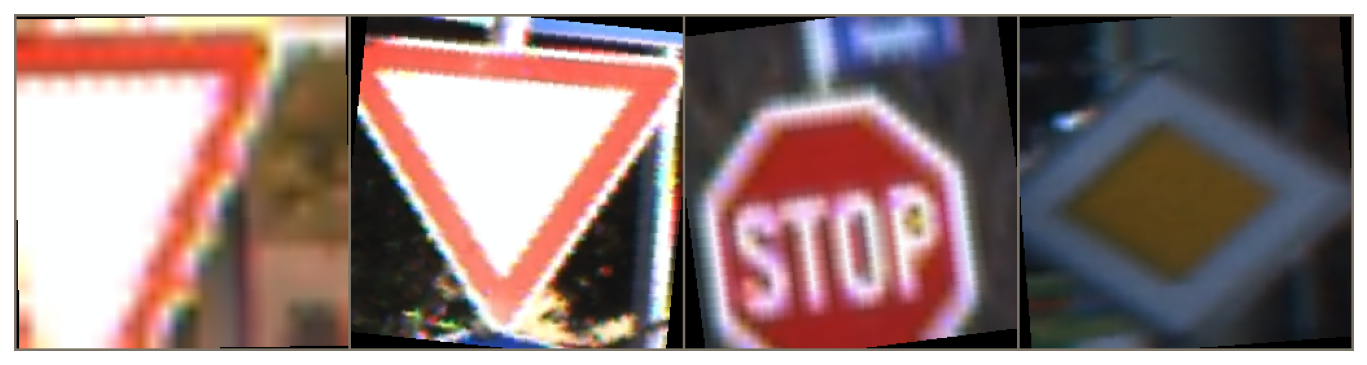

In [ ]:
inputs, classes = next(iter(dataloader['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

**Using a Pretrained model Resnet34 for prediction**

In [ ]:
model = models.resnet34(pretrained = True)
n_features = model.fc.in_features
model.fc = nn.Linear(n_features,len(class_names))
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
loss = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(),lr= 0.01)

In [ ]:
nb_epochs = 5
for epoch in range(nb_epochs):
  losses1 =[]
  accuracies = []
  model.train()
  for batch in dataloader['train']:
    x,y = batch
    x = x.cuda()
    #print(x.size())
    l = model(x)
    #import pdb;pdb.set_trace()
    J = loss(l,y.cuda())
    optimiser.zero_grad()

    J.backward()
    optimiser.step()
    
    losses1.append(J.item())
    accuracies.append(y.cuda().eq(l.detach().argmax(dim=1)).float().mean())
  print("Epoch "+str(epoch+1),"Training Loss: "+str(torch.tensor(losses1).mean()))
  print("Training Accuracy "+str(torch.tensor(accuracies).mean()))
  losses = []
  accuracies = []
  model.eval()
  for batch in dataloader['val']:
    x,y = batch
    x = x.cuda()
    with torch.no_grad():
      l = model(x)
      J = loss(l,y.cuda())
      losses.append(J.item())
      accuracies.append(y.cuda().eq(l.detach().argmax(dim=1)).float().mean())
  print("Epoch "+str(epoch+1),"Validation Loss: "+str(torch.tensor(losses).mean()))
  print("Validation Accuracy "+str(torch.tensor(accuracies).mean()))
  print(" ")      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Training Loss: tensor(0.3426)
Training Accuracy tensor(0.8797)
Epoch 1 Validation Loss: tensor(0.0166)
Validation Accuracy tensor(0.9935)
 
Epoch 2 Training Loss: tensor(0.1213)
Training Accuracy tensor(0.9579)
Epoch 2 Validation Loss: tensor(0.0013)
Validation Accuracy tensor(1.)
 
Epoch 3 Training Loss: tensor(0.0810)
Training Accuracy tensor(0.9740)
Epoch 3 Validation Loss: tensor(0.0070)
Validation Accuracy tensor(0.9968)
 
Epoch 4 Training Loss: tensor(0.0569)
Training Accuracy tensor(0.9815)
Epoch 4 Validation Loss: tensor(0.0049)
Validation Accuracy tensor(0.9984)
 
Epoch 5 Training Loss: tensor(0.0512)
Training Accuracy tensor(0.9831)
Epoch 5 Validation Loss: tensor(0.0107)
Validation Accuracy tensor(0.9984)
 


**Testing Some Prediction**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['stop', 'give_way', 'priority_road', 'give_way']


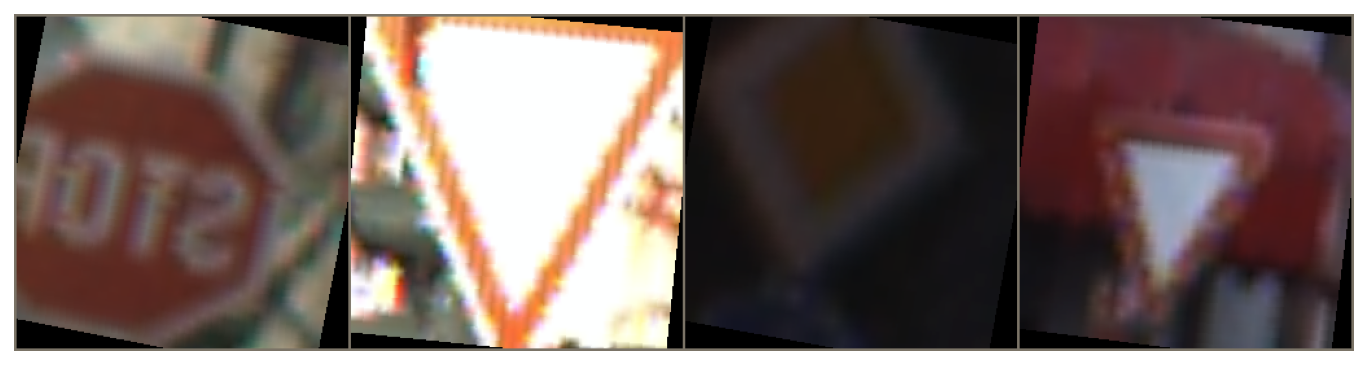

In [ ]:

inputs, classes = next(iter(dataloader['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

In [ ]:
def get_predictions(model,data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs,labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      
      _,preds = torch.max(outputs,dim=1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions  = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tesnor(real_values).cpu()
  return predictions,real_values


In [ ]:
def show_predictions(model,class_names,n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i,(inputs,labels) in enumerate(dataloader['test']):
      inputs = inputs.to(device)
      labels = inputs.to(device)

      outputs = model(inputs)
      _,preds = torch.max(outputs,dim=1)

      for j in range(inputs.shape[0]):
        i = int(preds[j])
        print(i)
        images_handeled += 1
        #print(class_names[j])
        ax = plt.subplot(n_images//2,2,images_handeled)
        ax.axis('off')
        print("Class Names = "+str(class_names[j]))
        ax.set_title(f'predicted:{class_names[i]}')
        imshow(inputs.cpu().data[j],class_name[i])

        if images_handeled == n_images:
          return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
Class Names = give_way
n
0
Class Names = no_entry
n
0
Class Names = priority_road
n
0
Class Names = stop
n
2
Class Names = give_way
_
2
Class Names = no_entry
_
2
Class Names = priority_road
_
2
Class Names = stop
_


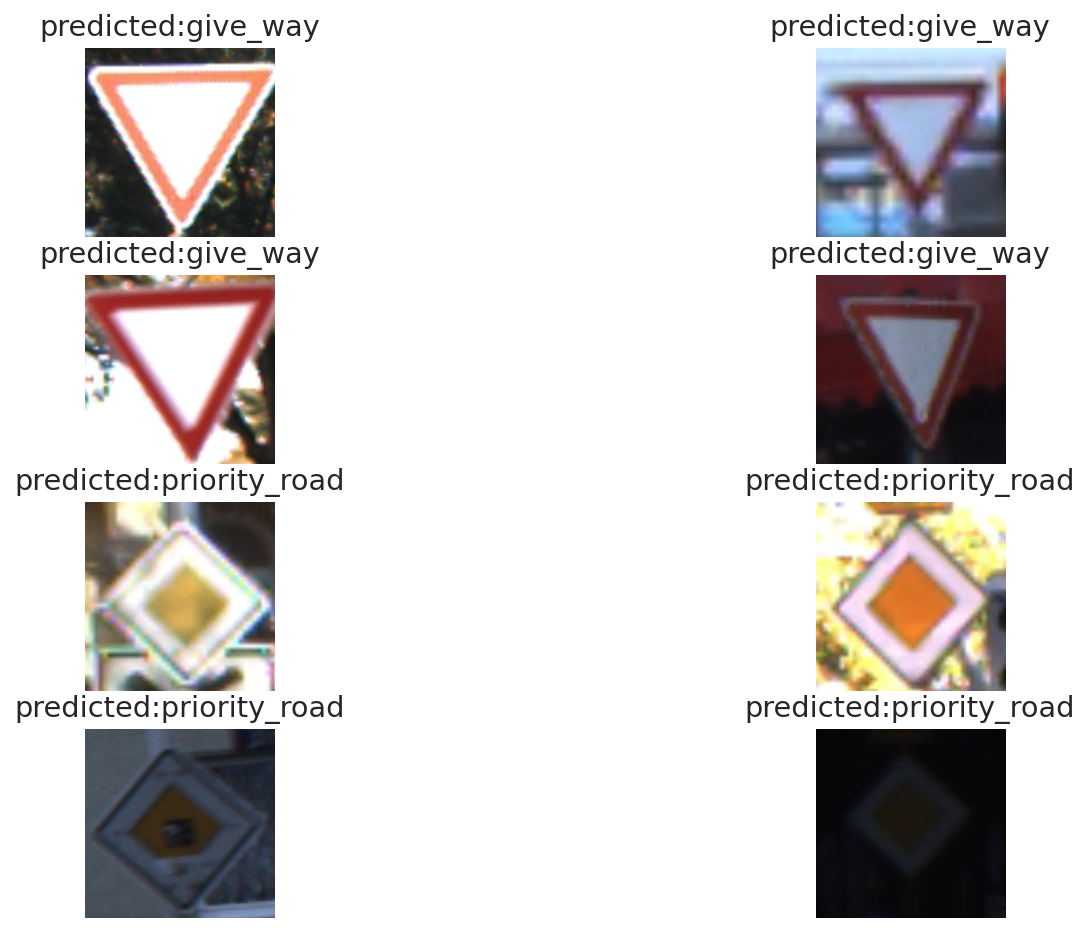

In [ ]:
show_predictions(model,class_names,n_images=8)